In [1]:
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd


In [2]:
# Criar um grupo para as colunas de problema: Asma,Desnutrição,Diabetes,DPOC,Hipertensão arterial,Obesidade,Pré-natal,Puericultura,Puerpério (até 42 dias),Saúde sexual e reprodutiva,Tabagismo,Usuário de álcool,Usuário de outras drogas,Saúde mental,Reabilitação,D.Transmissíveis - Dengue,Doenças transmissíveis - DST,D.Transmissíveis - Hanseníase,D.Transmissíveis - Tuberculose,Rast. câncer de mama,Rast. câncer do colo do útero,Rast. risco cardiovascular
problemas = ['Asma','Desnutrição','Diabetes','DPOC','Hipertensão arterial','Obesidade','Pré-natal','Puericultura','Puerpério (até 42 dias)','Saúde sexual e reprodutiva','Tabagismo','Usuário de álcool','Usuário de outras drogas','Saúde mental','Reabilitação','D.Transmissíveis - Dengue','Doenças transmissíveis - DST','D.Transmissíveis - Hanseníase','D.Transmissíveis - Tuberculose','Rast. câncer de mama','Rast. câncer do colo do útero','Rast. risco cardiovascular']

In [3]:
# Definir escopo para df_filtrado

data_inicio = '2023-01-01'
data_fim = '2023-12-01'
municipio = 'SÃO PAULO'
df = pd.read_csv('../painel/data/producao.csv')
df_filtrado = df[(df['Data'] >= data_inicio) & (df['Data'] <= data_fim) & (df['Municipio'] == municipio)]

# Ler o arquivo populacao.csv
populacao = pd.read_csv('../painel/data/populacao.csv')

def normaliza(df, populacao):
    '''Agrupa os dados por município e normaliza os casos por 100.000 habitantes'''
    # Mesclar o DataFrame original com o DataFrame de população
    df = pd.merge(df, populacao[['Ibge', 'populacao']], on='Ibge')

    # Selecionar colunas de casos (excluindo as colunas não numéricas e a população)
    casos = df.drop(columns=['Ano', 'Mes', 'Municipio', 'Uf', 'Data', 'Ibge', 'populacao'])

    # Normalizar os casos pela população do município e multiplicar por 100.000
    df_normalizado = casos.div(df['populacao'], axis=0) * 100000

    # Re-adicionar as colunas que foram removidas
    df_normalizado['Data'] = df['Data']
    df_normalizado['Municipio'] = df['Municipio']
    df_normalizado['Uf'] = df['Uf']
    df_normalizado['Ibge'] = df['Ibge']
    df_normalizado['populacao'] = df['populacao']

    # Reordenar as colunas para manter a mesma ordem que o DataFrame original
    df_normalizado = df_normalizado[['Data', 'Municipio', 'Uf', 'Ibge', 'populacao'] + list(casos.columns)]

    return df_normalizado


def normaliza_por_estado(df, populacao):
    '''Agrupa os dados por estado e normaliza os casos por 100.000 habitantes'''    
    # Agrupar população por estado
    populacao_estado = populacao.groupby('Uf')['populacao'].sum().reset_index()
    
    # Mesclar o DataFrame original com o DataFrame de população por estado
    df = pd.merge(df, populacao_estado, on='Uf', suffixes=('', '_estado'))
    
    # Selecionar colunas de casos (excluindo as colunas não numéricas e a população)
    casos = df.drop(columns=['Ano', 'Mes', 'Municipio', 'Uf', 'Data', 'Ibge', 'populacao', 'populacao_estado'])

    # Normalizar os casos pela população total do estado e multiplicar por 100.000
    df_normalizado = casos.div(df['populacao_estado'], axis=0) * 100000

    # Re-adicionar as colunas que foram removidas
    df_normalizado['Data'] = df['Data']
    df_normalizado['Municipio'] = df['Municipio']
    df_normalizado['Uf'] = df['Uf']
    df_normalizado['Ibge'] = df['Ibge']
    df_normalizado['populacao_estado'] = df['populacao_estado']

    # Reordenar as colunas para manter a mesma ordem que o DataFrame original
    df_normalizado = df_normalizado[['Data', 'Municipio', 'Uf', 'Ibge', 'populacao_estado'] + list(casos.columns)]

    return df_normalizado


df_normalizado = normaliza(df, populacao)


# Carregar o shapefile dos estados do Brasil (arquivo baixado shapefile do IBGE 2022)
shapefile_mun = '../mapas/BR_Municipios_2022/BR_Municipios_2022.shp' 
brasil = gpd.read_file(shapefile_mun)
# Agrupar dados por municipio para o ano de 2023
dados_filt_norm = df_normalizado[(df_normalizado['Data'] >= '2023-01-01') & (df_normalizado['Data'] <= '2023-12-31')].groupby('Ibge').sum().reset_index()
dados_filt_norm.drop(columns=['Data', 'Municipio', 'Uf', 'populacao'], inplace=True)
# Ajustar Ibge para string
dados_filt_norm['Ibge'] = dados_filt_norm['Ibge'].astype(str)
dados_filt_norm['Ibge'] = dados_filt_norm['Ibge'].str[:-2]
# remover ultimo digito do CD_MUN
brasil['CD_MUN'] = brasil['CD_MUN'].str[:-1]
# Juntar os dados com o shapefile
mapa = brasil.merge(dados_filt_norm, left_on='CD_MUN', right_on='Ibge')
mapa

Uf      Ibge  Municipio    Asma  Desnutrição  Diabetes   DPOC  \
58699   SP  355030.0  SÃO PAULO   7.180        6.771    95.656  3.459   
148581  SP  355030.0  SÃO PAULO   6.493        6.597    87.536  3.164   
154085  SP  355030.0  SÃO PAULO   8.165        5.867   103.592  4.109   
159609  SP  355030.0  SÃO PAULO  10.567        6.284   115.377  4.408   
182375  SP  355030.0  SÃO PAULO  12.032        8.647   113.086  4.889   
281787  SP  355030.0  SÃO PAULO   8.910        7.354    98.572  4.199   
313150  SP  355030.0  SÃO PAULO   7.738        5.275    88.809  3.514   
345487  SP  355030.0  SÃO PAULO  10.229        6.601   110.876  4.518   
429403  SP  355030.0  SÃO PAULO  11.949        6.589   126.542  4.823   
530043  SP  355030.0  SÃO PAULO   8.915        5.598   101.368  3.851   
559619  SP  355030.0  SÃO PAULO  10.311        6.925   113.709  4.449   
599338  SP  355030.0  SÃO PAULO   8.883        7.920   103.789  4.061   

        Hipertensão arterial  Obesidade  Pré-natal  ...  \
58699                157.916    106.091     70.096  ...   
148581               143.026    101.228     65.721  ...   
154085               188.644     98.505     89.675  ...   
159609               228.425     98.211     84.944  ...   
182375               213.210    115.745     89.443  ...   
281787               177.646    100.744     80.330  ...   
313150               159.992     86.132     76.216  ...   
345487               209.722    109.160     93.960  ...   
429403               247.140    106.001     90.058  ...   
530043               188.934     86.763     81.314  ...   
559619               219.358    106.973     84.179  ...   
599338               185.545    115.766     84.482  ...   

        Encaminhamento intersetorial  Encaminhamento p/ CAPS  \
58699                          1.935                 754.000   
148581                         1.966                 542.000   
154085                         1.920                 923.000   
159609                         1.969                 717.000   
182375                         2.243                 831.000   
281787                         1.971                 745.000   
313150                         1.426                 716.000   
345487                         1.962                 923.000   
429403                         2.125                   1.004   
530043                         1.967                 797.000   
559619                         2.234                 794.000   
599338                         2.203                 783.000   

        Encaminhamento p/ internação h  Encaminhamento p/ serviço de a  \
58699                            144.0                            77.0   
148581                           172.0                            54.0   
154085                           124.0                           118.0   
159609                           126.0                            98.0   
182375                           183.0                           123.0   
281787                           166.0                            81.0   
313150                            99.0                            80.0   
345487                           143.0                           106.0   
429403                           145.0                            92.0   
530043                           100.0                           108.0   
559619                           163.0                           120.0   
599338                           173.0                           103.0   

        Encaminhamento p/ serviço espe  Encaminhamento p/ urgência  \
58699                           87.809                       1.819   
148581                          87.903                       2.060   
154085                          73.281                       1.683   
159609                          84.842                       1.937   
182375                         103.593                       2.229   
281787                          88.286                       2.071   
3131

In [4]:
df_norm_uf = normaliza_por_estado(df, populacao)

# Carregar o shapefile dos estados do Brasil (arquivo baixado shapefile do IBGE 2022)
shapefile_uf = '../mapas/BR_UF_2022/BR_UF_2022.shp' 
brasil_estados = gpd.read_file(shapefile_uf)
# Agrupar dados por municipio para o ano de 2023
df_norm_uf = df_norm_uf[(df_norm_uf['Data'] >= data_inicio) & (df_normalizado['Data'] <= data_fim)].groupby('Uf').sum().reset_index()
df_norm_uf.drop(columns=['Data', 'Municipio', 'Uf', 'populacao'], inplace=True)
# Ajustar Ibge para string
dados_filt_norm['Ibge'] = dados_filt_norm['Ibge'].astype(str)
dados_filt_norm['Ibge'] = dados_filt_norm['Ibge'].str[:-2]
# remover ultimo digito do CD_MUN
brasil['CD_MUN'] = brasil['CD_MUN'].str[:-1]
# Juntar os dados com o shapefile
mapa = brasil.merge(dados_filt_norm, left_on='CD_MUN', right_on='Ibge')
mapa

In [24]:
def normaliza_por_estado(df, populacao):
    '''Agrupa os dados por estado e normaliza os casos por 100.000 habitantes'''    
    # renomear coluna 'UF' para 'Uf'
    populacao.rename(columns={'uf': 'Uf'}, inplace=True)

    df = pd.merge(df, populacao[['Ibge', 'populacao']], on='Ibge')
    
    # Agrupar população por estado
    populacao_estado = populacao.groupby('Uf')['populacao'].sum().reset_index()
    
    # Mesclar o DataFrame original com o DataFrame de população por estado
    df = pd.merge(df, populacao_estado, on='Uf', suffixes=('', '_estado'))
    
    # Selecionar colunas de casos (excluindo as colunas não numéricas e a população)
    casos = df.drop(columns=['Ano', 'Mes', 'Municipio', 'Uf', 'Data', 'Ibge', 'populacao', 'populacao_estado'])

    # Normalizar os casos pela população total do estado e multiplicar por 100.000
    df_normalizado = casos.div(df['populacao_estado'], axis=0) * 100000

    # Re-adicionar as colunas que foram removidas
    df_normalizado['Data'] = df['Data']
    df_normalizado['Municipio'] = df['Municipio']
    df_normalizado['Uf'] = df['Uf']
    df_normalizado['Ibge'] = df['Ibge']
    df_normalizado['populacao_estado'] = df['populacao_estado']

    # Reordenar as colunas para manter a mesma ordem que o DataFrame original
    df_normalizado = df_normalizado[['Data', 'Municipio', 'Uf', 'Ibge', 'populacao_estado'] + list(casos.columns)]

    return df_normalizado


df_norm_uf = normaliza_por_estado(df, populacao)

# Carregar o shapefile dos estados do Brasil (arquivo baixado shapefile do IBGE 2022)
shapefile_uf = '../mapas/BR_UF_2022/BR_UF_2022.shp' 
brasil_estados = gpd.read_file(shapefile_uf)

df_norm_uf = df_norm_uf[(df_norm_uf['Data'] >= data_inicio) & (df_normalizado['Data'] <= data_fim)].groupby('Uf').sum().reset_index()
df_norm_uf.drop(columns=['Data', 'Municipio', 'Ibge', 'populacao_estado'], inplace=True)

# Juntar os dados com o shapefile
mapa_uf = brasil_estados.merge(df_norm_uf, left_on='SIGLA_UF', right_on='Uf')
mapa_uf

CD_UF                NM_UF SIGLA_UF       NM_REGIAO     AREA_KM2  \
0     12                 Acre       AC           Norte   164173.429   
1     13             Amazonas       AM           Norte  1559255.881   
2     15                 Pará       PA           Norte  1245870.704   
3     16                Amapá       AP           Norte   142470.762   
4     17            Tocantins       TO           Norte   277423.627   
5     21             Maranhão       MA      Nordeste\n   329651.496   
6     22                Piauí       PI      Nordeste\n   251755.481   
7     23                Ceará       CE      Nordeste\n   148894.447   
8     24  Rio Grande do Norte       RN      Nordeste\n    52809.599   
9     25              Paraíba       PB      Nordeste\n    56467.242   
10    26           Pernambuco       PE      Nordeste\n    98067.877   
11    27              Alagoas       AL      Nordeste\n    27830.661   
12    28              Sergipe       SE      Nordeste\n    21938.188   
13    29                Bahia       BA      Nordeste\n   564760.429   
14    31         Minas Gerais       MG       Sudeste\n   586513.983   
15    32       Espírito Santo       ES       Sudeste\n    46074.448   
16    33       Rio de Janeiro       RJ       Sudeste\n    43750.425   
17    35            São Paulo       SP       Sudeste\n   248219.485   
18    41               Paraná       PR           Sul\n   199298.981   
19    42       Santa Catarina       SC           Sul\n    95730.690   
20    43    Rio Grande do Sul       RS           Sul\n   281707.151   
21    50   Mato Grosso do Sul       MS  Centro-oeste\n   357142.082   
22    51          Mato Grosso       MT  Centro-oeste\n   903208.361   
23    52                Goiás       GO  Centro-oeste\n   340242.859   
24    53     Distrito Federal       DF  Centro-oeste\n     5760.784   
25    11             Rondônia       RO           Norte   237754.172   
26    14              Roraima       RR           Norte   223644.530   

                                             geometry  Uf         Asma  \
0   POLYGON ((-68.79282 -10.99957, -68.79367 -10.9...  AC   518.262695   
1   POLYGON ((-56.76292 -3.23221, -56.76789 -3.242...  AM   465.012254   
2   MULTIPOLYGON (((-48.97548 -0.19834, -48.97487 ...  PA   479.747124   
3   MULTIPOLYGON (((-51.04561 -0.05088, -51.05422 ...  AP   443.361710   
4   POLYGON ((-48.2483 -13.19239, -48.24844 -13.19...  TO   820.349853   
5   MULTIPOLYGON (((-44.5868 -2.23341, -44.58696 -...  MA   247.970786   
6   POLYGON ((-42.47034 -3.48377, -42.46126 -3.484...  PI   451.647620   
7   POLYGON ((-37.87162 -4.3664, -37.87109 -4.3670...  CE   738.172907   
8   MULTIPOLYGON (((-35.18728 -5.78987, -35.18707 ...  RN   843.971319   
9   MULTIPOLYGON (((-34.7958 -7.175, -34.79578 -7....  PB   787.136645   
10  MULTIPOLYGON (((-35.04823 -8.60936, -35.04756 ...  PE   618.019548   
11  MULTIPOLYGON (((-35.287 -9.14489, -35.28699 -9...  AL   702.066441   
12  MULTIPOLYGON (((-37.01203 -10.92784, -37.01267...  SE   846.663251   
13  MULTIPOLYGON (((-39.26447 -8.61413, -39.26341 ...  BA   527.103791   
14  POLYGON ((-42.51148 -14.98627, -42.50964 -14.9...  MG  1084.841548   
15  MULTIPOLYGON (((-40.27883 -20.33437, -40.27883...  ES   907.385357   
16  MULTIPOLYGON (((-42.00612 -22.88563, -42.00634...  RJ   341.148631   
17  MULTIPOLYGON (((-46.47312 -22.70498, -46.47289...  SP   957.282511   
18  MULTIPOLYGON (((-48.30974 -25.49328, -48.27691...  PR  1775.775841   
19  MULTIPOLYGON (((-49.23653 -26.03711, -49.2365 ...  SC  1853.546371   
20  MULTIPOLYGON (((-51.71873 -31.85463, -51.71941...  RS  1370.980218   
21  POLYGON ((-54.68379 -23.8305, -54.68569 -23.83...  MS   657.441494   
22  POLYGON ((-56.0716 -17.17062, -56.07246 -17.17...  MT   495.594065   
23  POLYGON ((-47.33502 -15.58733, -47.33512 -15.5...  GO   572.767505   
24  POLYGON ((-48.01472 -16.04996, -48.01573 -16.0...  DF     0.959434   
25  POLYGON ((-62.60021 -13.01675, -62.59999 -13.0...  RO   407.430708   
26  POLYGON ((-6

In [28]:
mapa_uf.columns

Index(['CD_UF', 'NM_UF', 'SIGLA_UF', 'NM_REGIAO', 'AREA_KM2', 'geometry', 'Uf',
       'Asma', 'Desnutrição', 'Diabetes',
       ...
       'Encaminhamento interno no dia', 'Encaminhamento intersetorial',
       'Encaminhamento p/ CAPS', 'Encaminhamento p/ internação h',
       'Encaminhamento p/ serviço de a', 'Encaminhamento p/ serviço espe',
       'Encaminhamento p/ urgência', 'Avaliação / diagnóstico',
       'Procedimentos clínicos / terap', 'Prescrição terapêutica'],
      dtype='object', length=222)

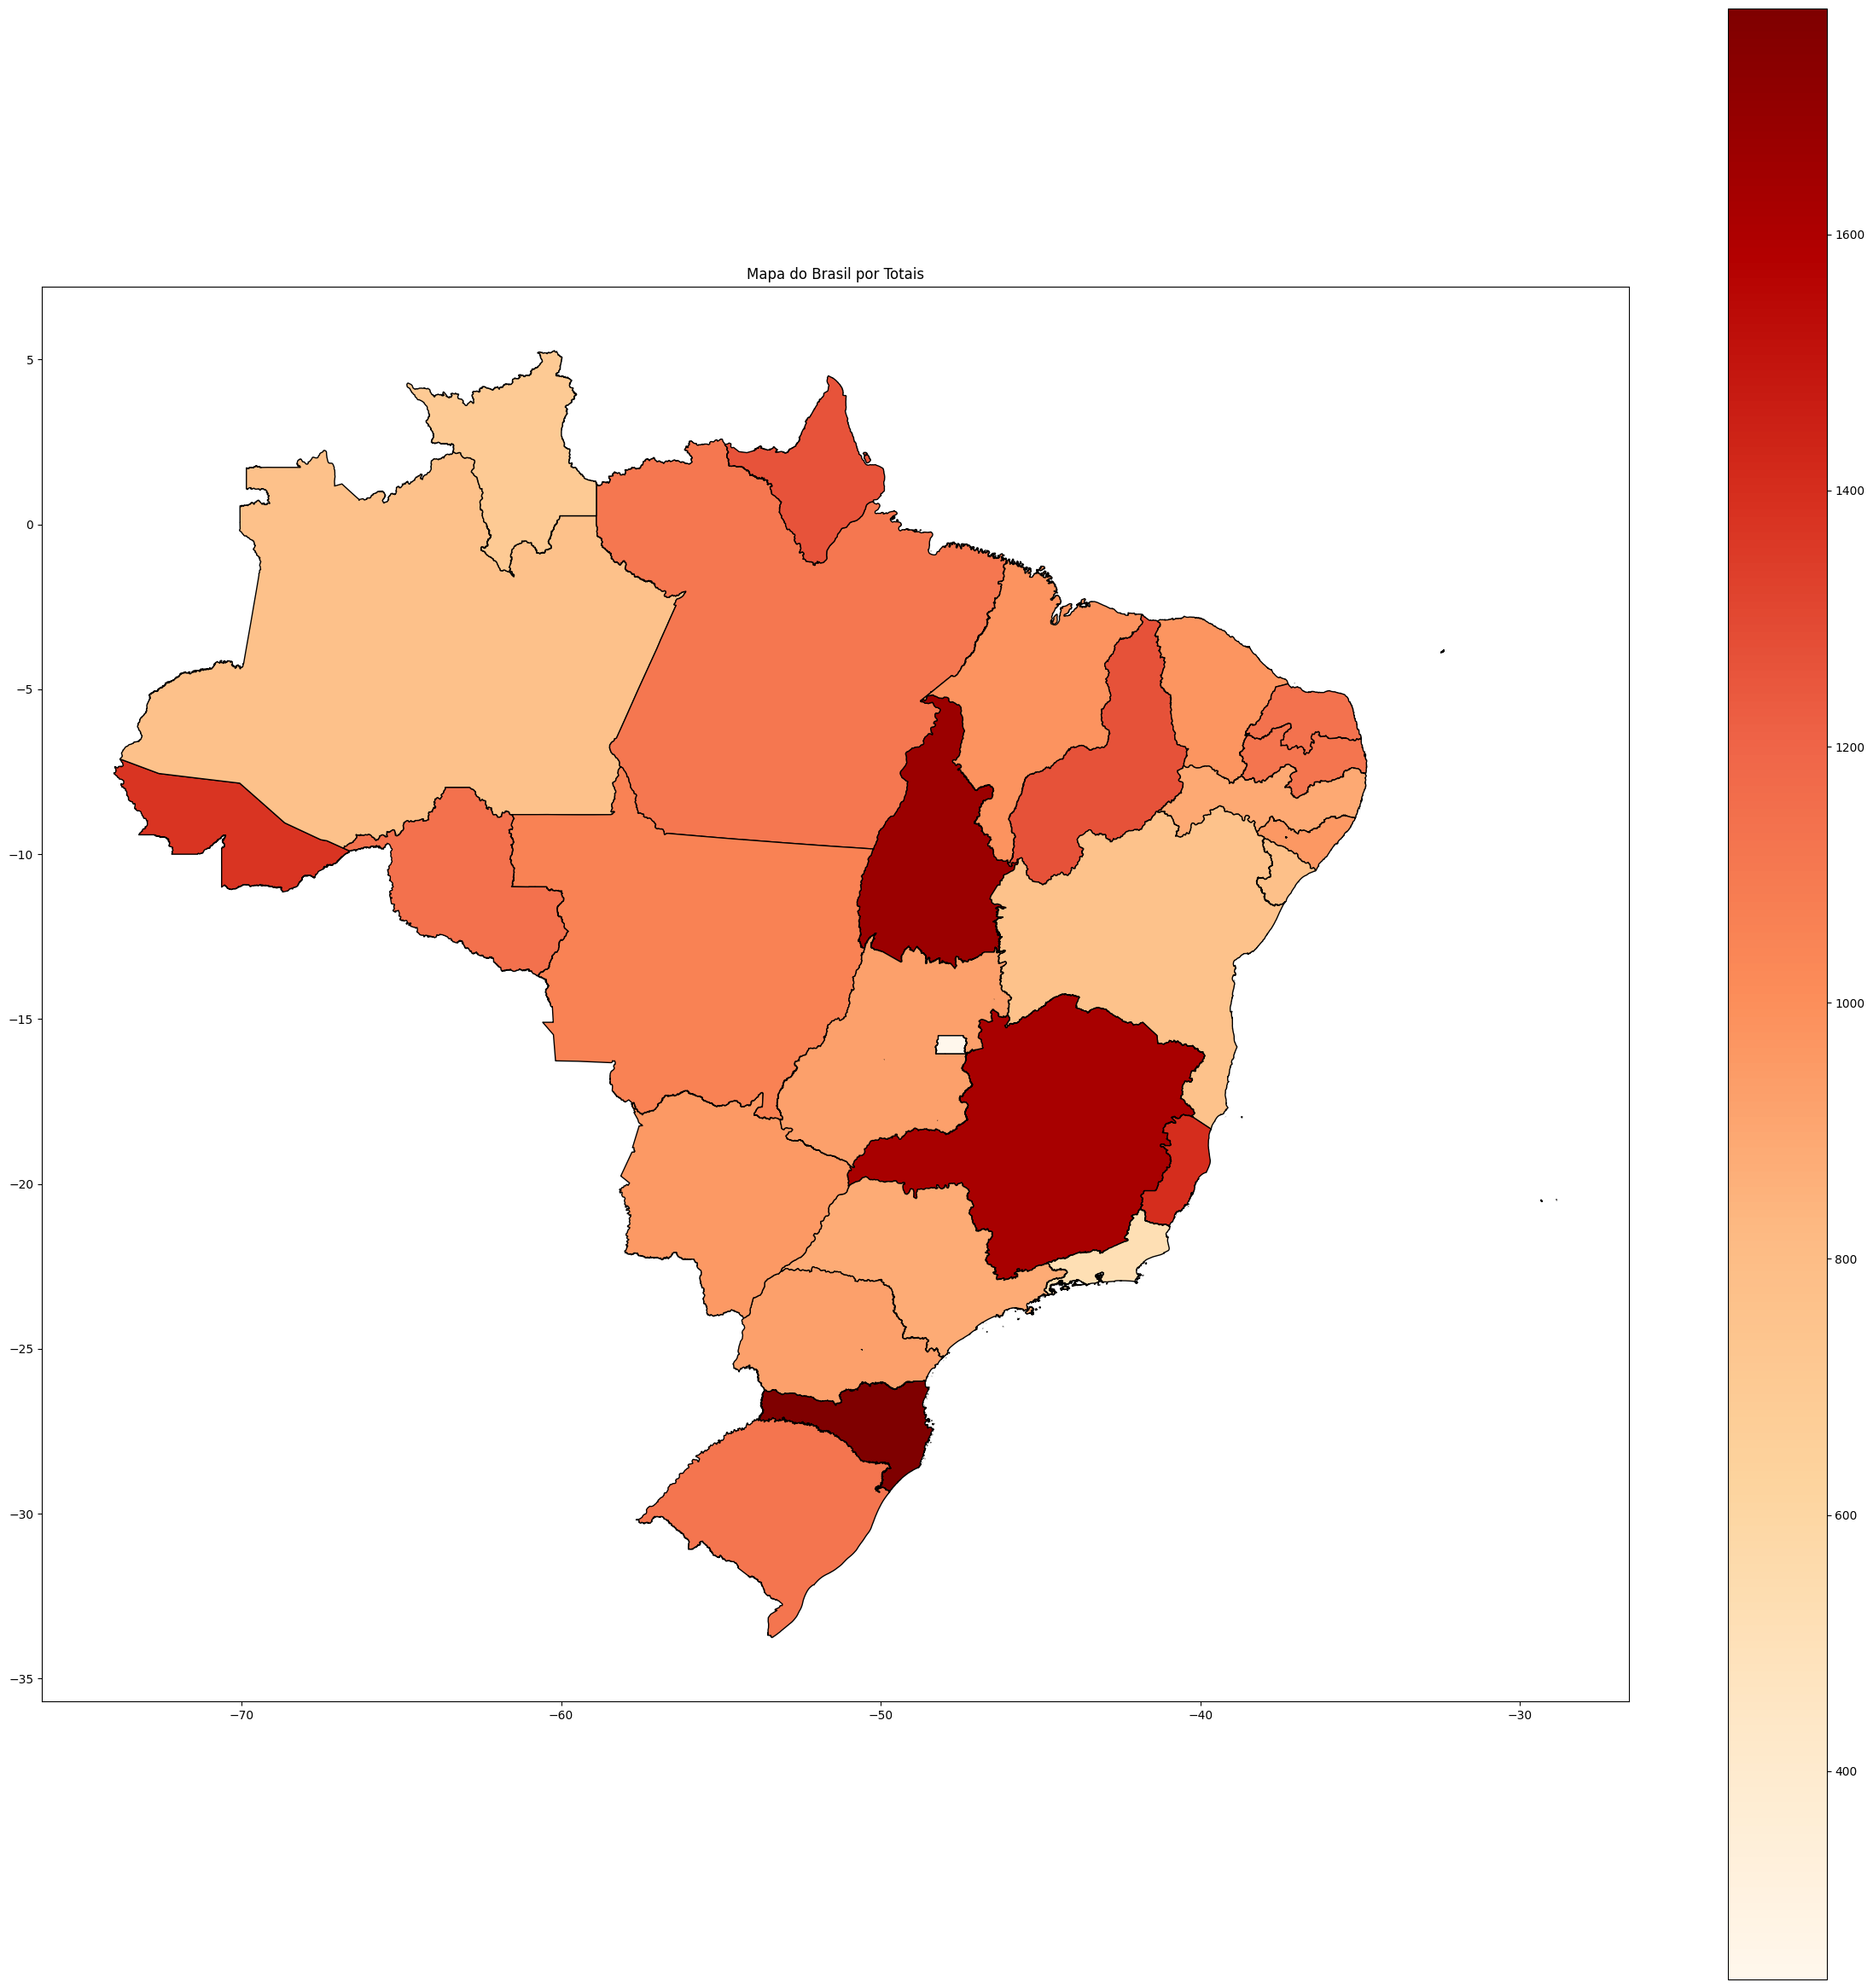

In [33]:
# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
mapa_uf.plot(column='Desnutrição', ax=ax, legend=True,
          cmap='OrRd',  # Mapa de cores
          edgecolor='black')  # Cor da borda dos estados

# Adicionar título
plt.title('Mapa do Brasil por Totais')

# Mostrar o mapa
plt.show()

In [44]:
import plotly.graph_objects as go

fig = go.Figure(go.Choroplethmapbox(
    geojson=mapa_uf.geometry.__geo_interface__,
    locations=mapa_uf.index,
    z=mapa_uf['Desnutrição'],
    colorscale='reds',
    colorbar_title='Desnutrição',
))

fig.update_layout(mapbox_style="open-street-map", 
                  margin={"r":0,"t":50,"l":0,"b":0})
fig.show()


In [41]:
# Simplificar a geometria (ajuste o parâmetro 'tolerance' conforme necessário)
mapa_uf['geometry'] = mapa_uf['geometry'].simplify(tolerance=0.01)


In [43]:
# Plotar o mapa para uma coluna específica, por exemplo, 'Asma'
fig = px.choropleth(
    mapa_uf,
    geojson=mapa_uf.geometry,   # Usar a geometria do shapefile
    locations=mapa_uf.index,    # Localizações baseadas no índice do DataFrame
    color='Asma',            # Coluna que queremos mapear
    color_continuous_scale='reds',
    title='Casos de Asma por Estado no Brasil - 2023'
)

# Ajustar as configurações do mapa
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

# Mostrar o mapa
fig.show()

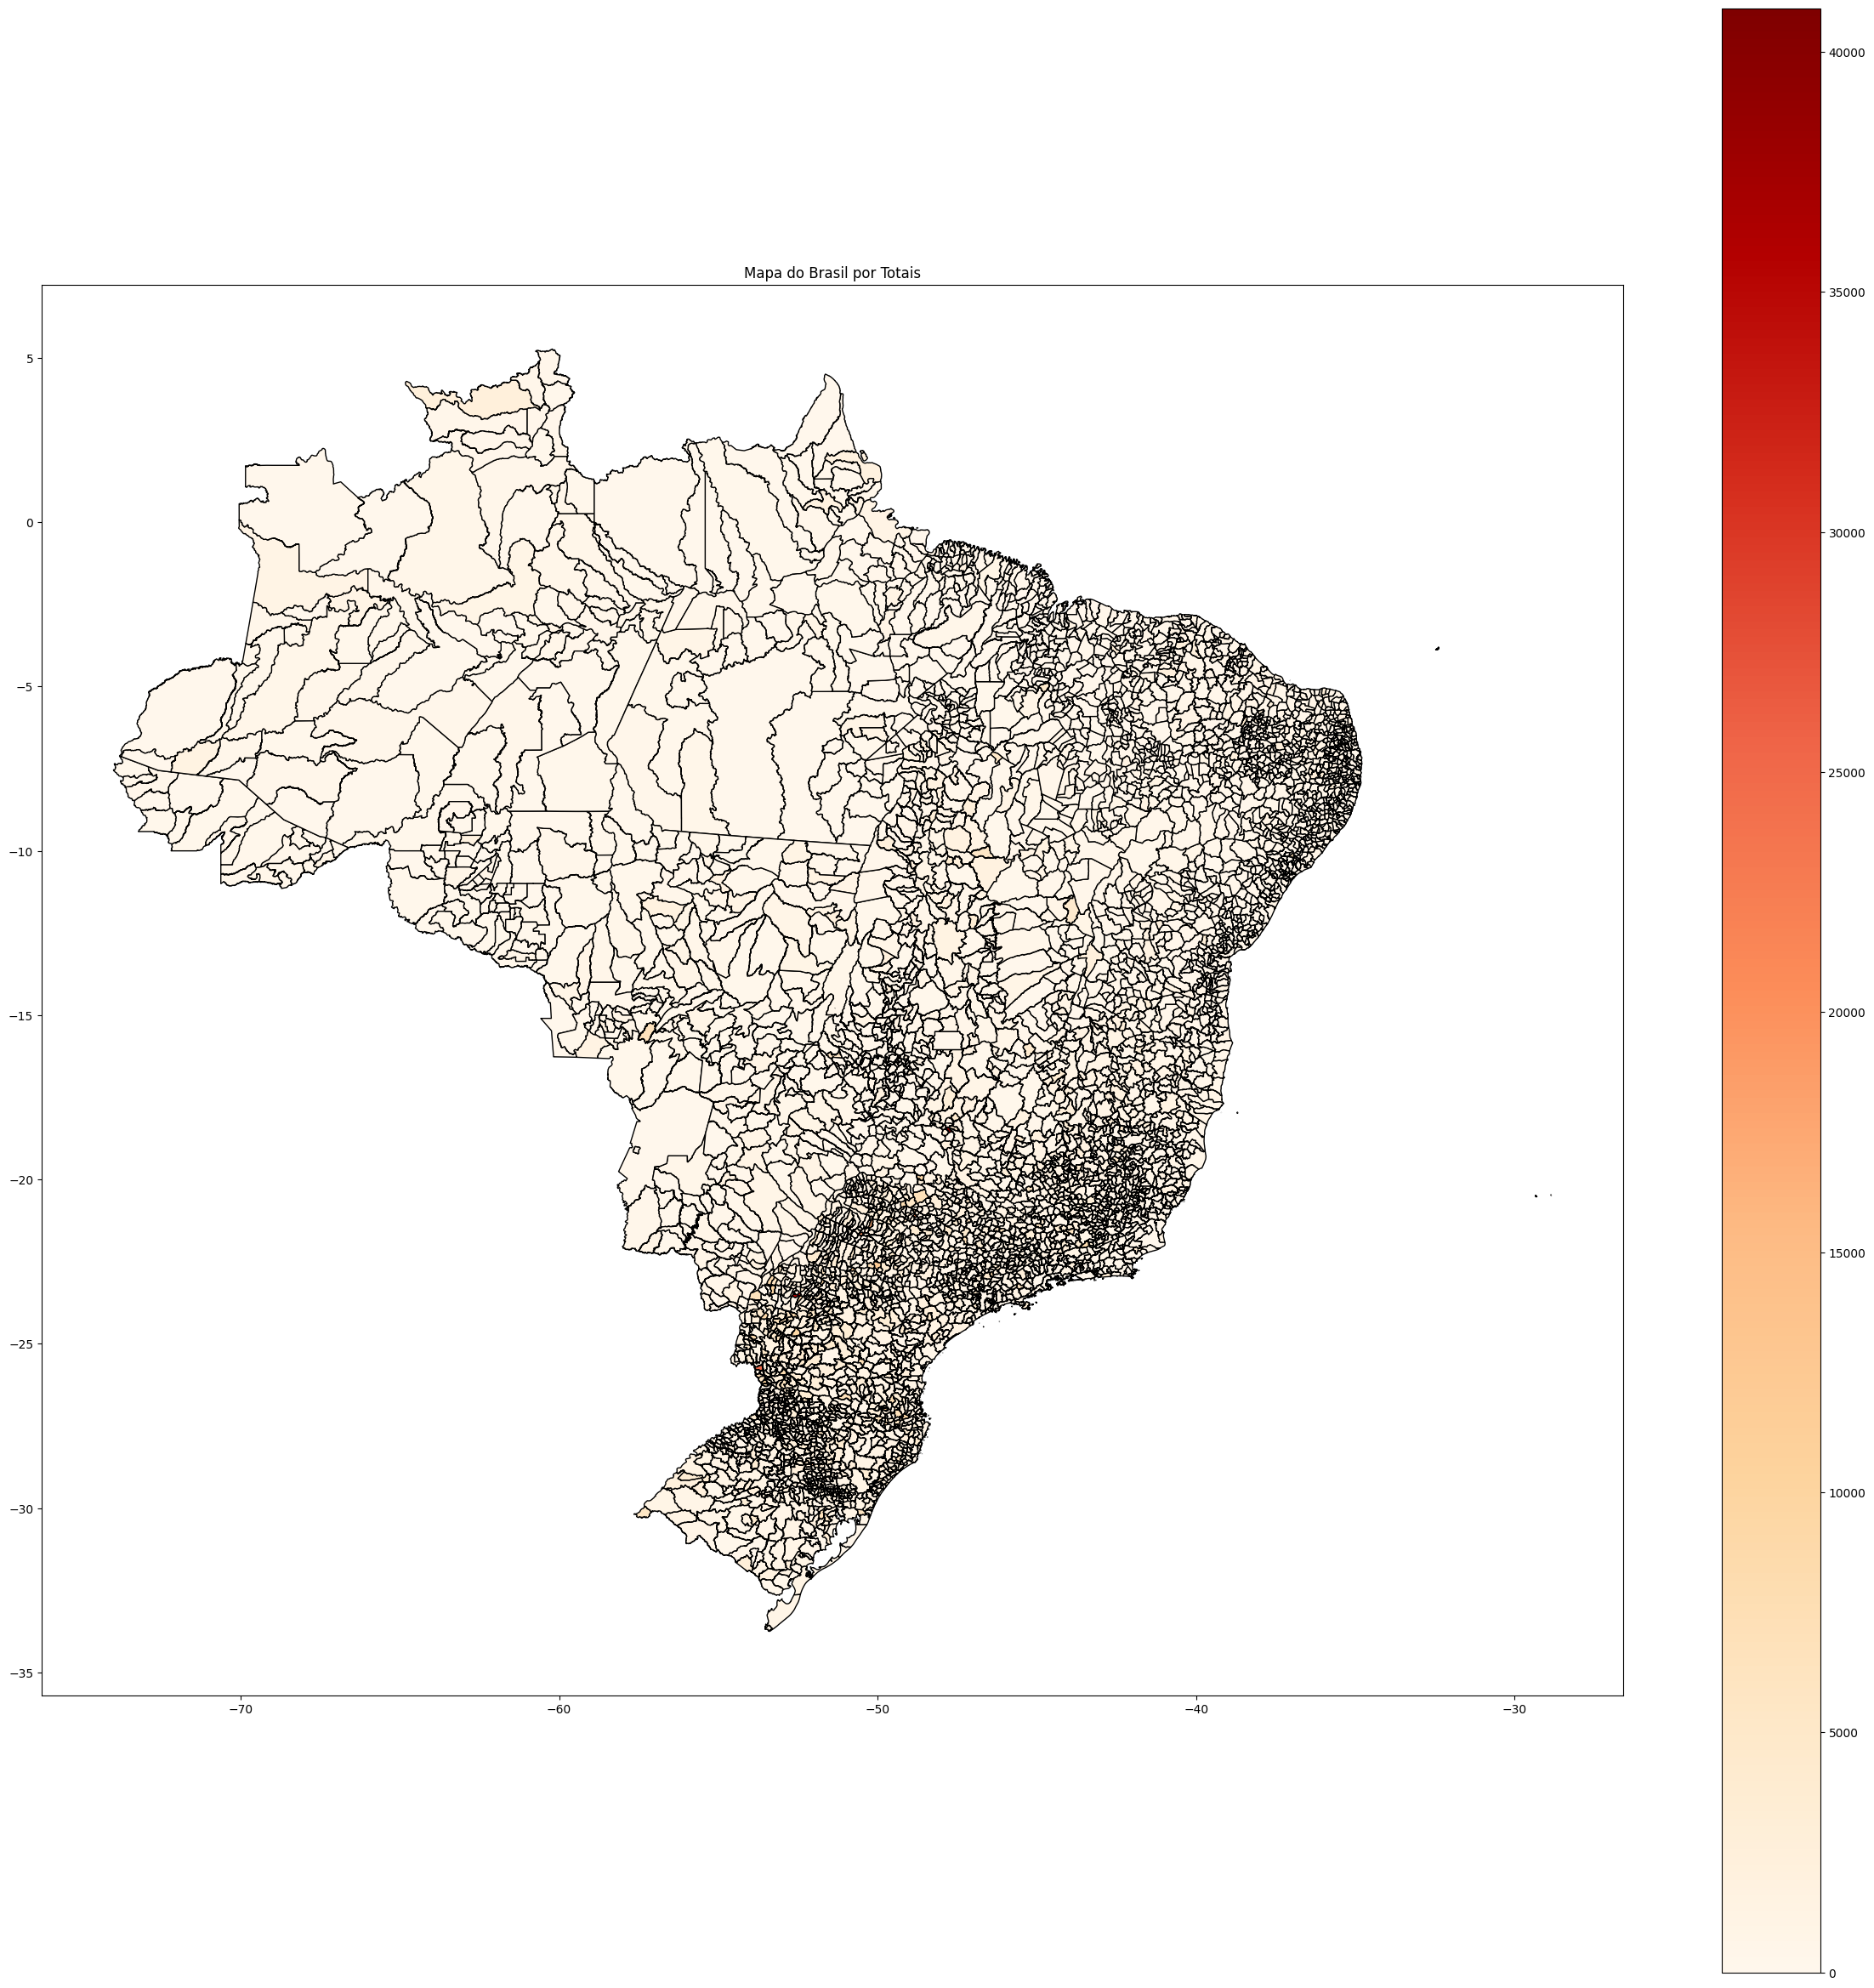

In [9]:
import matplotlib.pyplot as plt


# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
mapa.plot(column='Asma', ax=ax, legend=True,
          cmap='OrRd',  # Mapa de cores
          edgecolor='black')  # Cor da borda dos estados

# Adicionar título
plt.title('Mapa do Brasil por Totais')

# Mostrar o mapa
plt.show()

In [5]:
# Apresentar um compartivo entre os problemas do municipio de São Paulo e o estado de São Paulo
df_estado = df[(df['Data'] >= data_inicio) & (df['Data'] <= data_fim) & (df['Uf'] == 'SP') & (df['Municipio'] != 'SÃO PAULO')]
df_estado



Uf      Ibge             Municipio  Asma  Desnutrição  Diabetes  DPOC  \
57528   SP  350310.0                ARANDU   0.0          0.0     1.000   0.0   
57531   SP  353880.0                PIRAJU   7.0         17.0   791.000   8.0   
57533   SP  354105.0              PRATÂNIA   7.0          6.0    35.000   3.0   
57538   SP  355540.0               UBATUBA  64.0        100.0     1.115  47.0   
57567   SP  351512.0         EMILIANÓPOLIS   2.0          8.0   139.000   3.0   
...     ..       ...                   ...   ...          ...       ...   ...   
629973  SP  354400.0        RIO DAS PEDRAS   0.0          0.0     0.000   0.0   
629979  SP  355640.0  VARGEM GRANDE DO SUL   0.0          0.0     0.000   0.0   
631318  SP  350335.0             ARCO-ÍRIS   0.0          0.0     0.000   0.0   
633246  SP  350115.0              ALUMÍNIO   0.0          0.0     0.000   0.0   
633879  SP  350115.0              ALUMÍNIO   0.0          0.0     0.000   0.0   

        Hipertensão arterial  Obesidade  Pré-natal  ...  \
57528                  0.000        0.0        5.0  ...   
57531                  1.763       32.0      189.0  ...   
57533                 69.000        6.0       29.0  ...   
57538                  1.847      105.0      801.0  ...   
57567                324.000       53.0       25.0  ...   
...                      ...        ...        ...  ...   
629973                 0.000        0.0        0.0  ...   
629979                 0.000        0.0        0.0  ...   
631318                 0.000        0.0        0.0  ...   
633246                 0.000        0.0        0.0  ...   
633879                 0.000        0.0        0.0  ...   

        Encaminhamento intersetorial  Encaminhamento p/ CAPS  \
57528                            0.0                     0.0   
57531                            0.0                     0.0   
57533                            0.0                     0.0   
57538                            6.0                    25.0   
57567                            1.0                     0.0   
...                              ...                     ...   
629973                           0.0                     0.0   
629979                           0.0                     0.0   
631318                           0.0                     0.0   
633246                           0.0                     0.0   
633879                           0.0                     0.0   

        Encaminhamento p/ internação h  Encaminhamento p/ serviço de a  \
57528                              0.0                             0.0   
57531                              0.0                             0.0   
57533                              0.0                             0.0   
57538                              1.0                             0.0   
57567                              0.0                             0.0   
...                                ...                             ...   
629973                             0.0                             0.0   
629979                             0.0                             0.0   
631318                             0.0                             0.0   
633246                             0.0                             0.0   
633879                             0.0                             0.0   

        Encaminhamento p/ serviço espe  Encaminhamento p/ urgência  \
57528                            0.000                         0.0   
57531                          492.000                         0.0   
57533                           47.000                         0.0   
57538                            2.104                         8.0   
57567                          125.000                         0.0   
...                                ...                         ...   
629973                           0.000                         0.0   
629979                           0.000                         0.0   
631318                           0.000

In [17]:
# Apresentar um gráfico de barras Horizontal para avaliar os problemas de saúde em df_filtrado somando todos os meses
fig = go.Figure()
fig.add_trace(go.Bar(y=problemas, x=df_filtrado[problemas].sum(), orientation='h'))
fig.show()


In [28]:
# fill nan with 0
df

Uf      Ibge             Municipio  Asma  Desnutrição  Diabetes  DPOC  \
0       PI  220900.0   RIO GRANDE DO PIAUÍ     1            2         5     1   
1       PR  410520.0            CERRO AZUL     2            2       145     2   
2       RJ  330190.0              ITABORAÍ    86           15       970    28   
3       RS  431410.0           PASSO FUNDO   161           52       594    51   
4       GO  520630.0        CRISTIANÓPOLIS     5            0        68     1   
...     ..       ...                   ...   ...          ...       ...   ...   
635162  RS  432057.0      SETE DE SETEMBRO     0            0         0     0   
635163  RS  430222.0  BOA VISTA DO CADEADO     0            0         0     0   
635164  SP  350900.0              CAIEIRAS     0            0         0     0   
635165  PR  412110.0         QUINTA DO SOL     0            0         0     0   
635166  RS  431475.0        POÇO DAS ANTAS     0            0         0     0   

        Hipertensão arterial  Obesidade  Pré-natal  ...  \
0                         25          2         32  ...   
1                        280         39         49  ...   
2                          2        171        586  ...   
3                          1        269        853  ...   
4                        168         15         11  ...   
...                      ...        ...        ...  ...   
635162                     0          0          0  ...   
635163                     0          0          0  ...   
635164                     0          0          0  ...   
635165                     0          0          0  ...   
635166                     0          0          0  ...   

        Encaminhamento p/ internação h  Encaminhamento p/ serviço de a  \
0                                  0.0                             0.0   
1                                  0.0                             0.0   
2                                  2.0                             2.0   
3                                  0.0                             0.0   
4                                  0.0                             0.0   
...                                ...                             ...   
635162                             0.0                             0.0   
635163                             0.0                             0.0   
635164                             0.0                             0.0   
635165                             0.0                             0.0   
635166                             0.0                             0.0   

        Encaminhamento p/ serviço espe  Encaminhamento p/ urgência  \
0                                7.000                         0.0   
1                                0.000                         0.0   
2                                1.192                        16.0   
3                              825.000                         0.0   
4                                9.000                         0.0   
...                                ...                         ...   
635162                           0.000                         0.0   
635163                           0.000                         0.0   
635164                           0.000                         0.0   
635165                           0.000                         0.0   
635166                           0.000                         0.0   

        Retorno p/ cuidado continuado/  Retorno para consulta agendada_y  \
0                                222.0                              32.0   
1                                  9.0                             353.0   
2                                2.184                             2.743   
3                                5.367                             2.731   
4                                 31.0                             449.0   
...                                ...                               ...   
635162                             0.0                          

In [36]:
# converter todas as colunas numéricas para int
for column in df.columns:
    if column not in ['Ibge', 'Ano', 'Mes', 'Municipio', 'Uf', 'Data'] and df[column].dtype == 'object':
        # remover os pontos e converter para int
        try:
            df[column] = df[column].str.replace('.', '').astype(int)
        except Exception as e:
            df.drop(column, axis=1, inplace=True)

In [38]:
# gravar df em csv
df.to_csv('../etl/data/producao.csv', index=False)